In [2]:
%load_ext autoreload 
%autoreload 2
from dcmnet.analysis import *
from dcmnet.data import prepare_batches
from dcmnet.modules import MessagePassingModel
from dcmnet.utils import apply_model
from dcmnet.loss import esp_mono_loss_pots, pred_dipole
from dcmnet.plotting import evaluate_dc

import matplotlib.pyplot as plt
from tqdm import tqdm 

print(jax.devices())

# Model hyperparameters.
features = 16
max_degree = 2
num_iterations = 2
num_basis_functions = 8
cutoff = 4.0
n_dcm = 2

# Create and train model.
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
    n_dcm=n_dcm,
)

PARAMS = pd.read_pickle(
    "/pchem-data/meuwly/boittier/home/jaxeq/all_runs/runs7/"\
    "20240917-103238dcm-2-espw-1000-qm9-esp40000-0.npz-re-False/best_100000_params.pkl")

PARAMS2 = pd.read_pickle(
"/pchem-data/meuwly/boittier/home/jaxeq/all_runs/runs7/"\
"20240830-171111dcm-2-espw-1000-qm9-esp40000-0.npz-re-False/best_1000_params.pkl")



[cuda(id=1)]


<Figure size 100x100 with 0 Axes>

In [3]:
gathered_data = [pd.read_pickle(_) for _ in Path("/pchem-data/meuwly/boittier/home/analysis/20240830-171111dcm-2-espw-1000-qm9-esp40000-0").glob("*.pkl")]

In [4]:
def get_data_dict(path):
    return {_.stem: pd.read_pickle(_) for _ in Path(path).glob("*.pkl")}



In [5]:
MBIS = get_data_dict("/pchem-data/meuwly/boittier/home/analysis/MBIS")

In [7]:
KEYS = list(MBIS.keys())
k = KEYS[0]

In [9]:
DCM2 = get_data_dict(
    "/pchem-data/meuwly/boittier/home/analysis/20240830-171111dcm-2-espw-1000-qm9-esp40000-0")

In [10]:
DCM3 = get_data_dict(
    "/pchem-data/meuwly/boittier/home/analysis/20240830-165613dcm-3-espw-1000-qm9-esp40000-0")

In [11]:
DCM4 = get_data_dict(
    "/pchem-data/meuwly/boittier/home/analysis/20240830-163232dcm-4-espw-1000-qm9-esp40000-0")

In [79]:
MBIS[k].keys()

dict_keys(['mono', 'dipo', 'quad', 'closest_atom_type', 'mask', 'rmse_mono', 'rmse_dipo', 'rmse_quad', 'rmse_mono_masked', 'rmse_dipo_masked', 'rmse_quad_masked', 'D_mono', 'D_dipo', 'D_mae_mono', 'D_mae_dipo', 'D', 'D_xyz'])

<Axes: >

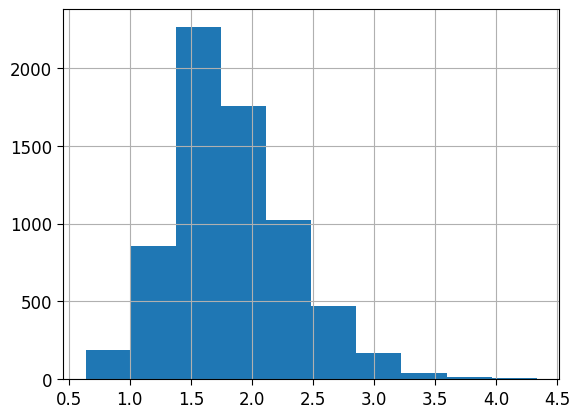

In [75]:
_ = [ MBIS[k] for k in KEYS]
rmse_mono = np.array([ float(MBIS[k]["rmse_mono"]) for k in KEYS])
pd.Series([float(_) for _ in list(rmse_mono)]).hist()

<Axes: >

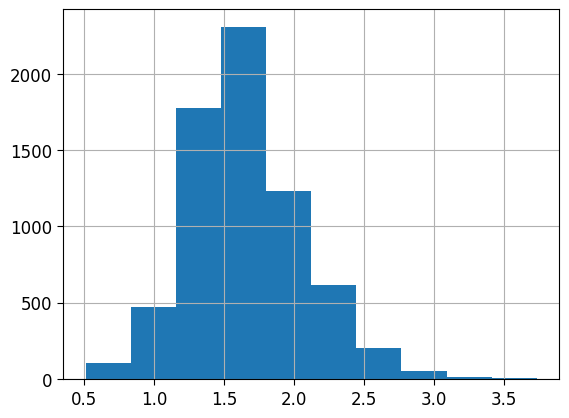

In [76]:
rmse_dipo = np.array([ float(MBIS[k]["rmse_dipo"]) for k in KEYS])
pd.Series([float(_) for _ in list(rmse_dipo)]).hist()

<Axes: >

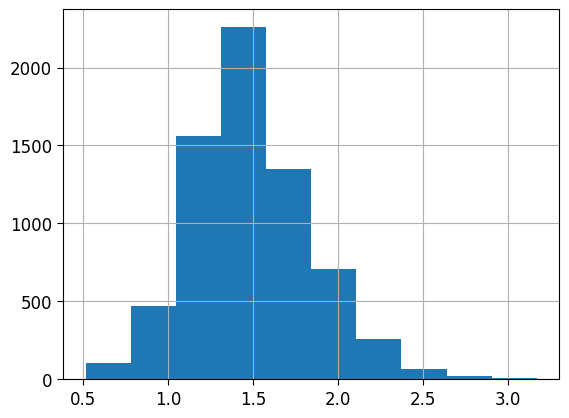

In [77]:
rmse_quad = np.array([ float(MBIS[k]["rmse_quad"]) for k in KEYS])
pd.Series([float(_) for _ in list(rmse_quad)]).hist()

In [15]:
MBISDF = pd.DataFrame(_)

In [33]:
DM2DF = pd.DataFrame([DCM2[k] for k in KEYS])

In [34]:
DM3DF = pd.DataFrame([DCM3[k] for k in KEYS])

In [35]:
DM4DF = pd.DataFrame([DCM4[k] for k in KEYS])

<Axes: >

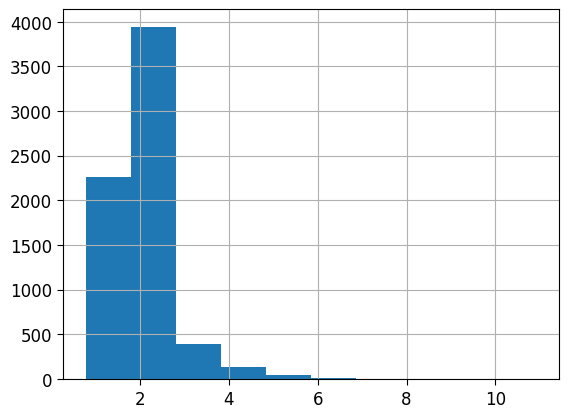

In [72]:
pd.Series([float(_) for _ in list(DM2DF["rmse_model"])]).hist()


<Axes: >

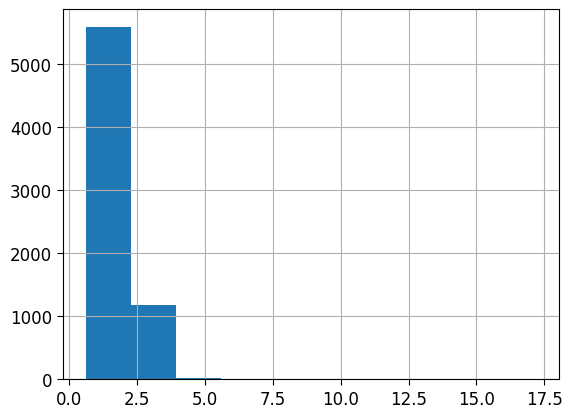

In [73]:
pd.Series([float(_) for _ in list(DM3DF["rmse_model"])]).hist()


<Axes: >

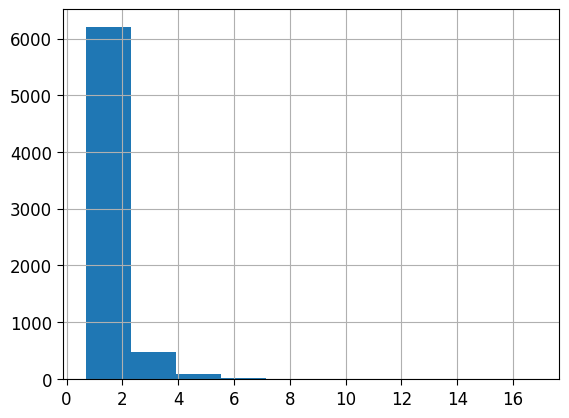

In [74]:
pd.Series([float(_) for _ in list(DM4DF["rmse_model"])]).hist()

In [84]:
rmse_mono = np.array([ float(MBIS[k]["D_mae_mono"]) for k in KEYS])
pd.Series([float(_) for _ in list(rmse_mono)]).describe() #.hist(color="r")

count    6785.000000
mean        0.195037
std         0.099167
min         0.000123
25%         0.122607
50%         0.182246
75%         0.254083
max         0.652840
dtype: float64

In [83]:
pd.Series([float(_) for _ in list(DM2DF["D_mae"])]).describe()

count    6785.000000
mean        0.178897
std         0.170760
min         0.003771
25%         0.089059
50%         0.137695
75%         0.211111
max         3.264247
dtype: float64

In [85]:
pd.Series([float(_) for _ in list(DM3DF["D_mae"])]).describe()

count    6785.000000
mean        0.141550
std         0.148321
min         0.003430
25%         0.073386
50%         0.114395
75%         0.171733
max         5.409748
dtype: float64

In [87]:
pd.Series([float(_) for _ in list(DM4DF["D_mae"])]).describe()

count    6785.000000
mean        0.156292
std         0.179796
min         0.001587
25%         0.073528
50%         0.116735
75%         0.178982
max         4.807563
dtype: float64

In [413]:
params_path = "/pchem-data/meuwly/boittier/home/jaxeq/all_runs/runs7/"\
    "20240917-103238dcm-2-espw-1000-qm9-esp40000-0.npz-re-False/best_100000_params.pkl"

In [416]:
model, params = create_model_and_params(params_path)

In [426]:
path = Path("/pchem-data/meuwly/boittier/home/jaxeq/misc")
paths = list(path.glob("*"))
path = paths[3]
path

PosixPath('/pchem-data/meuwly/boittier/home/jaxeq/misc/dsgdb9nsd_130481')

In [427]:
len(paths)

6785

In [439]:
multipoles(path)

{'mono': array([-1.57251967e-04, -3.89688485e-04, -8.37155019e-04, ...,
         6.03865959e-10,  6.03865959e-10,  6.03865959e-10]),
 'dipo': array([-2.17947508e-04, -4.75518065e-04, -9.58040795e-04, ...,
         6.15405036e-10,  6.15405036e-10,  6.15405036e-10]),
 'quad': array([-2.46676154e-04, -5.05583831e-04, -9.89895138e-04, ...,
         6.15405992e-10,  6.15405992e-10,  6.15405992e-10]),
 'closest_atom_type': array(['H', 'H', 'H', ..., 'H', 'H', 'H'], dtype='<U1'),
 'mask': array([ True,  True,  True, ...,  True,  True,  True]),
 'rmse_mono': Array(2.5785172, dtype=float32),
 'rmse_dipo': Array(2.3860228, dtype=float32),
 'rmse_quad': Array(2.0463996, dtype=float32),
 'rmse_mono_masked': Array(0.64240754, dtype=float32),
 'rmse_dipo_masked': Array(0.5469865, dtype=float32),
 'rmse_quad_masked': Array(0.4507401, dtype=float32),
 'D_mono': Array([0.12374781, 0.27461293, 0.0003081 ], dtype=float32),
 'D_dipo': Array([0.13663724, 0.3379609 , 0.0005268 ], dtype=float32),
 'D_mae_mon

<Figure size 640x480 with 0 Axes>

In [418]:
path

PosixPath('/pchem-data/meuwly/boittier/home/jaxeq/misc/dsgdb9nsd_129885')

In [423]:
dcmnet(path, params_path)

20240917-103238dcm-2-espw-1000-qm9-esp40000-0
/pchem-data/meuwly/boittier/home/analysis/20240917-103238dcm-2-espw-1000-qm9-esp40000-0


In [238]:
list(np.load(Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/spice-esp-dip-63-0.npz").keys())

['R',
 'Z',
 'N',
 'D',
 'com',
 'Dxyz',
 'mono',
 'esp',
 'id',
 'n_grid',
 'vdw_surface']

In [239]:
data = np.load(Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/qm9-esp-dip-6907-3.npz")

In [260]:
batch.keys()

dict_keys(['R', 'Z', 'N', 'D', 'com', 'Dxyz', 'mono', 'esp', 'id', 'n_grid', 'vdw_surface', 'dst_idx', 'src_idx', 'batch_segments'])

In [274]:
mono, dipo = apply_model(message_passing_model, PARAMS2, batch, 1)

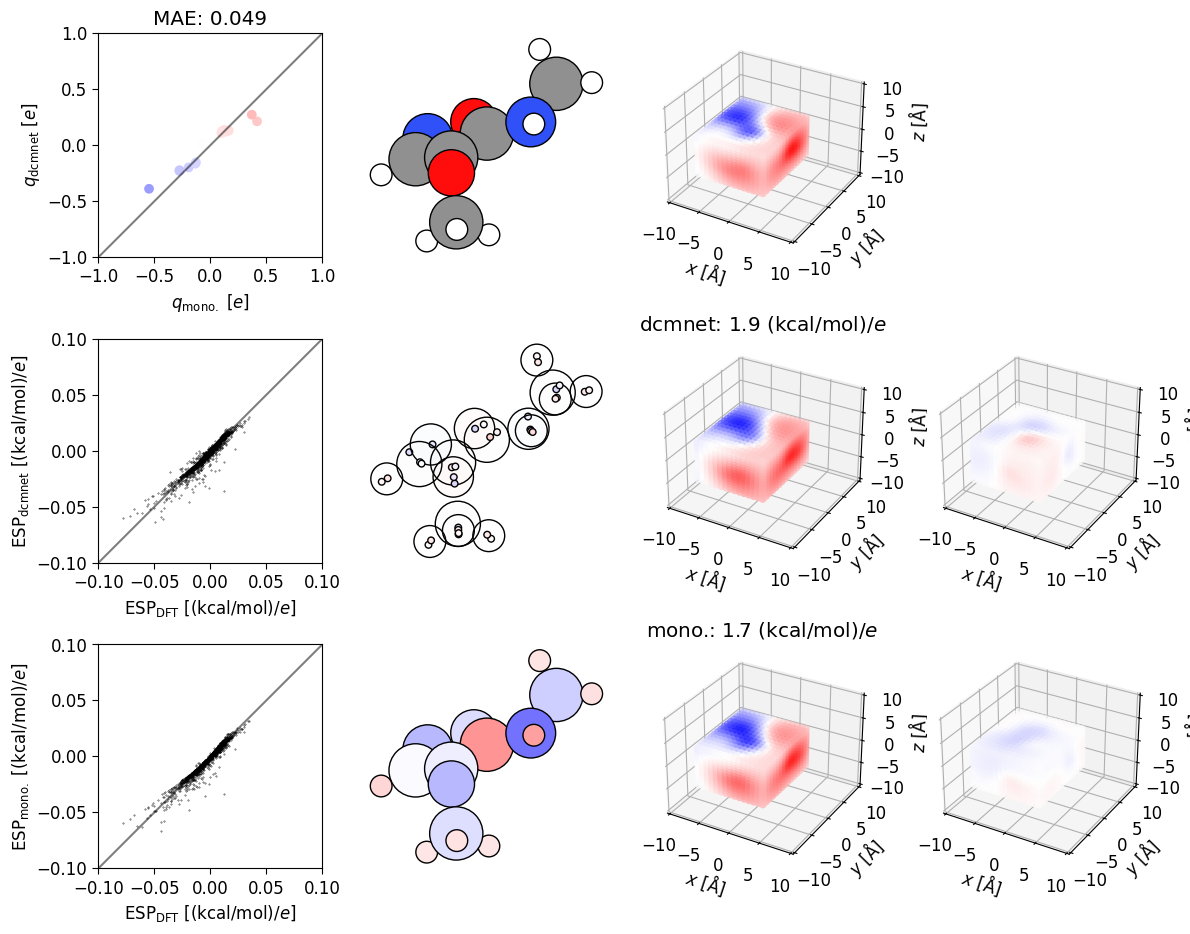

In [275]:
error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 1, message_passing_model.n_dcm,
                                               plot=True,
                                               id=False,
                                         )  

In [398]:
message_passing_model

MessagePassingModel(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 8
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 2
)

In [276]:
esp_dc_pred = esp_mono_loss_pots(
    dipo, mono, batch["vdw_surface"][0], batch["mono"], 1, 2
)

In [277]:
esp_dc_pred

Array([[-5.9854425e-04, -1.1163130e-03, -1.8688906e-03, ...,
         5.4842531e-10,  5.4842531e-10,  5.4842531e-10]], dtype=float32)

In [279]:
pred_dipole(dipo, batch["com"], mono.reshape(120)) 

Array([[ 1.4839166 , -0.37764528, -0.08600583]], dtype=float32)

In [346]:
path = Path("/pchem-data/meuwly/boittier/home/jaxeq/misc")
paths = list(path.glob("*"))
path = paths[1]
path

PosixPath('/pchem-data/meuwly/boittier/home/jaxeq/misc/dsgdb9nsd_129885')

In [348]:
id = path.stem
index = int(np.argwhere(data["id"] == id))
_dict = {k:np.array(v[[index]]) for k,v in data.items()}
batch = prepare_batches(jax.random.PRNGKey(0), _dict, 1, True)[0]

In [360]:
mono, dipo = apply_model(message_passing_model, PARAMS2, batch, 1)

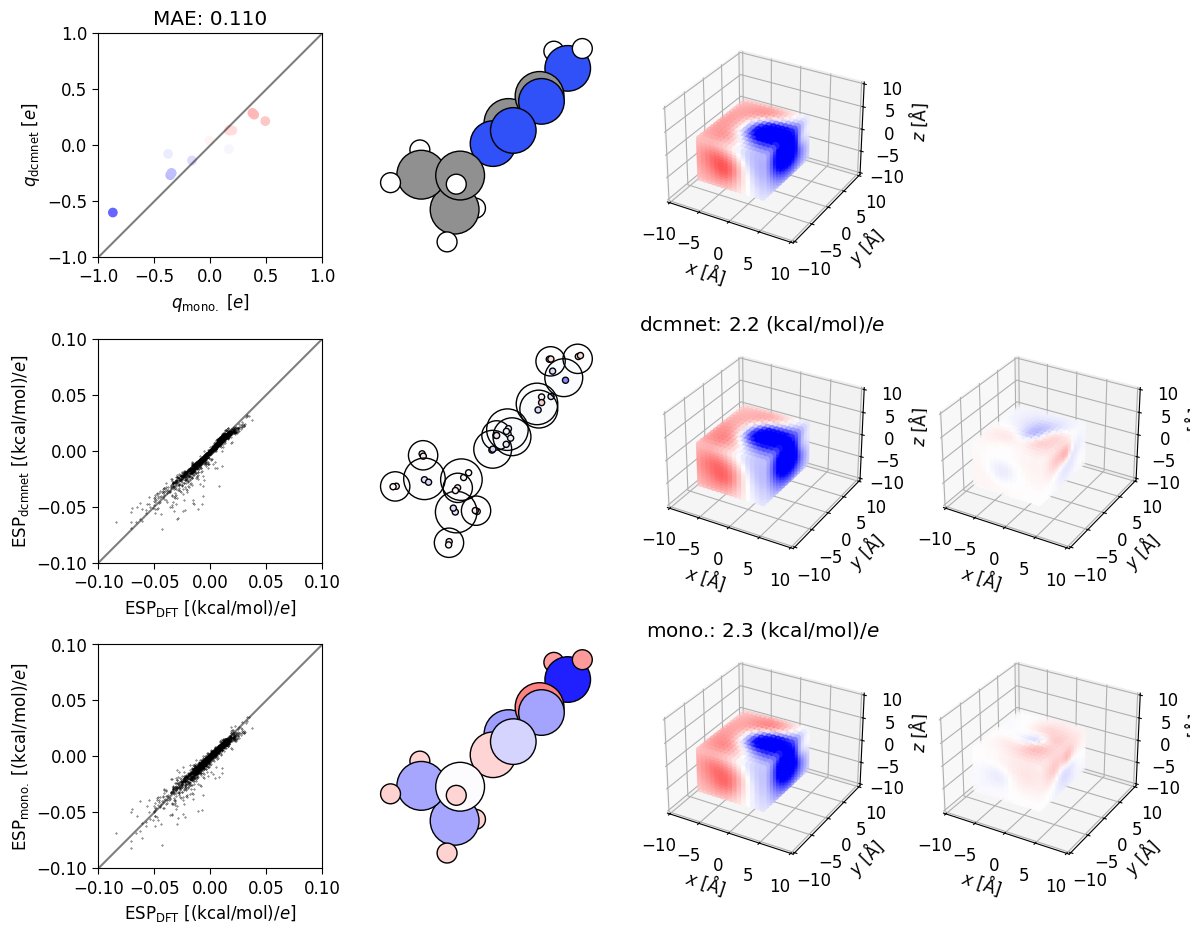

In [361]:
error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 1, message_passing_model.n_dcm,
                                               plot=True,
                                               id=False,
                                         )  

In [373]:
esp_dc_pred = esp_mono_loss_pots(
    dipo, mono, batch["vdw_surface"][0], batch["mono"], 1, 2
)

In [374]:
esp_dc_pred

Array([[ 4.0778751e-03,  4.5543481e-03,  4.9881758e-03, ...,
        -1.0900294e-09, -1.0900294e-09, -1.0900294e-09]], dtype=float32)

In [375]:
pred_dipole(dipo, batch["com"], mono.reshape(120)) 

Array([[-1.680133  , -0.10305855, -0.23762737]], dtype=float32)

In [376]:
outdata = prepare_mulitpoles_data(path)

In [377]:
mtp = multipoles(outdata)

distances (3200, 17)
vdw_radii (17,)


In [378]:
?cut_vdw

Signature: cut_vdw(grid, xyz, elements, vdw_scale=2.0)
File:      /home/boittier/jaxeq/dcmnet/analysis.py
Type:      function

In [388]:
mask, vdw = cut_vdw(outdata["grid"], outdata["xyz"], outdata["elements"], vdw_scale=2)

distances (3200, 17)
vdw_radii (17,)


In [389]:
vdw

array(['H', 'H', 'H', ..., 'H', 'H', 'H'], dtype='<U1')

In [390]:
import pandas as pd

In [391]:
pd.DataFrame(mask).describe()

,0
count,3200
unique,2
top,True
freq,2480


In [392]:
pd.DataFrame(distances).describe()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,...,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000,3048.000000
mean,8.198729,8.148585,7.527728,8.126639,7.817164,7.454949,7.908503,7.468350,7.854730,8.612159,...,8.639630,8.662463,8.150476,7.849365,8.068500,8.165274,8.051312,8.312952,7.532739,7.707702
std,2.928320,2.819721,2.035350,2.763841,2.445751,1.903653,2.525012,1.919641,2.418111,3.088460,...,3.137523,3.293270,2.674757,2.394911,2.517230,2.526163,2.398045,2.729768,2.124296,2.310690
min,1.606891,1.685158,1.611401,1.695297,1.706076,1.690054,1.934228,1.666481,1.606031,2.033110,...,1.605342,1.783973,1.612589,1.668907,1.677621,1.687170,1.625915,1.645915,1.665468,1.613611
25%,6.009627,5.966258,6.153193,5.986727,5.990544,6.140757,6.022147,6.145025,6.027874,6.168865,...,6.189311,6.059007,6.167875,6.143325,6.238326,6.390342,6.391626,6.265699,6.039984,6.080075
50%,7.798224,7.905096,7.611585,7.917693,7.597892,7.507851,7.676474,7.535908,7.741640,8.565068,...,8.604508,8.265777,8.175665,7.987764,8.155486,8.331435,8.196651,8.451406,7.524108,7.578827
75%,10.447738,10.255220,8.982380,10.203062,9.589387,8.834669,9.741919,8.858121,9.633695,11.001092,...,11.078438,11.314857,10.228795,9.608901,9.895219,9.958956,9.746352,10.288528,9.027826,9.322316
max,15.529264,15.712819,13.196735,15.653240,14.722178,12.727497,14.899000,12.803336,14.710154,16.926675,...,16.927623,16.551152,15.389946,13.921706,15.223774,15.426461,14.987846,16.118169,13.709881,14.209615


In [393]:
mask

array([ True,  True,  True, ...,  True,  True,  True])

4.2321124
1.0041205
2.193473


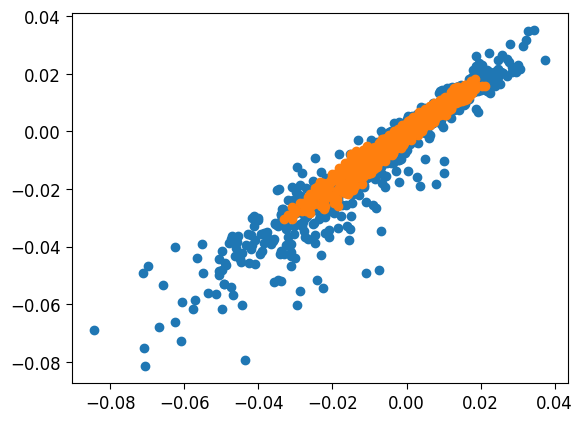

3.7635803
0.7688088
1.9092139


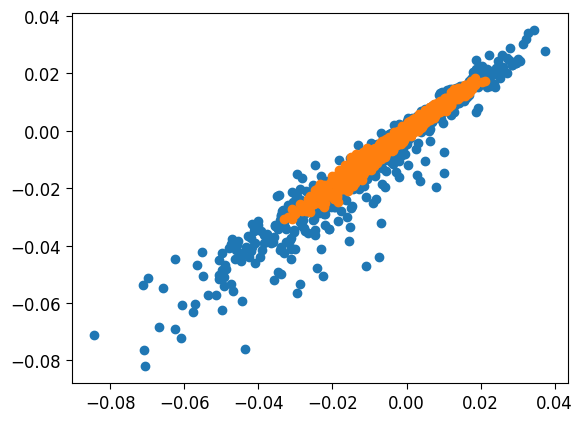

3.4171178
0.7264354
1.7424783


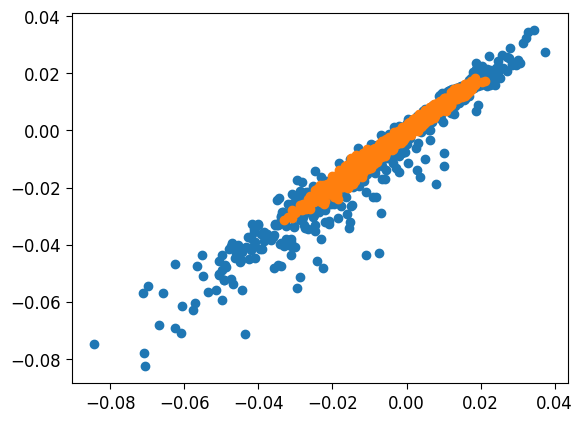

In [394]:
for k in ["mono", "dipo", "quad"]:
    plt.scatter(outdata["esp"][~mask], mtp[k][~mask])
    print(rmse(outdata["esp"][~mask], mtp[k][~mask]))
    plt.scatter(outdata["esp"][mask], mtp[k][mask])
    print(rmse(outdata["esp"][mask], mtp[k][mask]))
    print(rmse(outdata["esp"], mtp[k]))
    plt.show()

4.315133
0.7458006
2.1495705


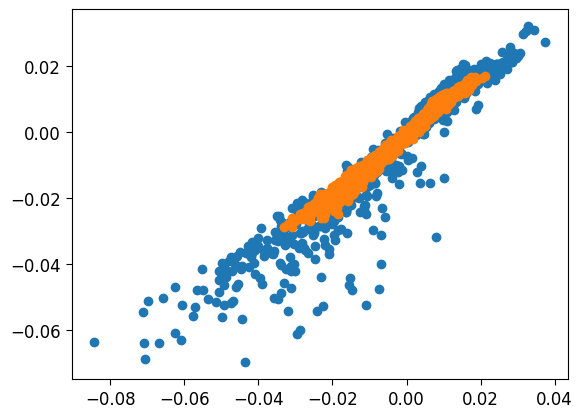

In [395]:
plt.scatter(outdata["esp"][~mask], esp_dc_pred[0][~mask])
print(rmse(outdata["esp"][~mask], esp_dc_pred[0][~mask]))
plt.scatter(outdata["esp"][mask], esp_dc_pred[0][mask])
print(rmse(outdata["esp"][mask], esp_dc_pred[0][mask]))
print(rmse(outdata["esp"], esp_dc_pred[0]))

In [396]:
esp_dc_pred.shape

(1, 3200)